![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

## Загрузка данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
RANDOM_SEED = 42

In [3]:
# # зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

## Первичный осмотр данных

In [4]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df = data.copy()

In [12]:
df.shape

(50000, 11)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [15]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Не похоже, чтобы признаки *Restaurant_id*, *URL_TA* и *ID_TA* несли в себе важную информацию для анализа. Избавимся от них.

In [16]:
df.drop(["Restaurant_id", "URL_TA", "ID_TA"], 1, inplace=True)

Переименуем столбцы для удобства:

In [17]:
df.columns = ["city", "c_style", "ranking", "p_range", "n_reviews", "reviews", "sample", "rating"]

In [18]:
df.sample(3)

,city,c_style,ranking,p_range,n_reviews,reviews,sample,rating
727,Edinburgh,"['Mexican', 'Vegetarian Friendly', 'Vegan Opti...",141.0,$$ - $$$,310.0,"[['Great food! Excellent customer service!', '...",0,0.0
6624,Edinburgh,"['Scottish', 'Vegetarian Friendly', 'Vegan Opt...",135.0,$$ - $$$,1351.0,"[['Excellent food and excellent service!', 'Ex...",0,0.0
9029,Munich,"['Cafe', 'European', 'Greek']",1311.0,$,5.0,"[[], []]",0,0.0


Посмотрим на распределение числовых переменных *ranking*, *rating* и *n_reviews*:

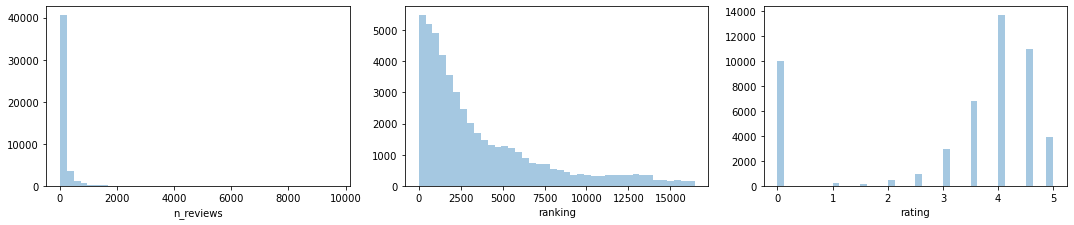

In [19]:
fig = plt.figure(figsize=(15,12))
for index, col in enumerate(df.loc[:, ["n_reviews", "ranking", "rating"]]):
    plt.subplot(4,3,index+1)
    sns.distplot(df.loc[:, col], kde=False, bins=40)
fig.tight_layout(pad=1.0)

## Очистка и подготовка данных
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   

### 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [20]:
df.isna().sum()

city             0
c_style      11590
ranking          0
p_range      17361
n_reviews     3200
reviews          2
sample           0
rating           0
dtype: int64

В признаках *c_style*, *p_range*, *reviews* и *n_reviews* наблюдаем пропуски.

Заполним два пропуска в признаке *reviews*:

In [21]:
df.reviews.value_counts()

[[], []]                                                                                               8112
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                       2
[['Delicious'], ['06/06/2017']]                                                                           2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]            2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]       2
                                                                                                       ... 
[['Excellent food!!!', 'Easy on the pocket'], ['11/17/2017', '11/05/2017']]                               1
[['Excellent lunch', 'Pleasant Neighborhood Cafe!'], ['01/04/2018', '06/27/2017']]                        1
[['Authentic and friendly', 'Great Vietnamese food'], ['07/22/2017', '03/24/2017']]                       1
[['Average', 'Very nice'], [

In [22]:
df.reviews.fillna(df.reviews.value_counts().index[0], inplace=True)

In [23]:
# df.dropna(thresh=6, inplace=True)
# df = df.reset_index(drop=True)
# print(f"Наш датасет стал меньше на {data.shape[0]-df.shape[0]} наблюдений")   

In [24]:
df.isna().sum()

city             0
c_style      11590
ranking          0
p_range      17361
n_reviews     3200
reviews          0
sample           0
rating           0
dtype: int64

Займемся признаком *n_reviews* (кол-во отзывов)

Пропуски в нём заполним, руководствуясь следующей логикой:
- 0 - если в столбце *reviews* пусто, т.е. len('[[], []]') == 8
- 1 - если в столбце *reviews* есть отзыв

Но прежде сохраним информацию о наблюдениях с пропусками:

In [25]:
df['n_reviews_isNAN'] = pd.isna(df['n_reviews']).astype('uint8')

In [26]:
df['n_reviews_isNAN'].value_counts()

0    46800
1     3200
Name: n_reviews_isNAN, dtype: int64

In [27]:
"""Функция проверяет длину значения из reviews; 
в зависимости от результата заполняет пропуски в n_reviews значением 1 или 0"""
def n_reviews(row):
    if pd.isnull(row.n_reviews):
        if len(row.reviews) > 8:
            return 1
        return 0
    return row.n_reviews

In [28]:
# Применим функцию
df["n_reviews"] = df.apply(n_reviews, 1)

In [29]:
df.head()

,city,c_style,ranking,p_range,n_reviews,reviews,sample,rating,n_reviews_isNAN
0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",0,0.0,0
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0
2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0


In [30]:
df.isna().sum()

city                   0
c_style            11590
ranking                0
p_range            17361
n_reviews              0
reviews                0
sample                 0
rating                 0
n_reviews_isNAN        0
dtype: int64

С пропусками в других признаках разберемся чуть позже. А пока сохраним информацию о наличии пропусков в этих признаках.

In [31]:
df['c_style_isNAN'] = pd.isna(df['c_style']).astype('uint8')
df['p_range_isNAN'] = pd.isna(df['p_range']).astype('uint8')

### 2. Обработка и добавление признаков

### reviews: Два последних отзыва и даты этих отзывов

Поработаем теперь с колонкой *reviews*. Нам нужно извлечь из нее информацию о датах.

In [32]:
df.reviews.value_counts()[:7]

[[], []]                                                                                               8114
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                       2
[['Delicious'], ['06/06/2017']]                                                                           2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]            2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]       2
[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                                    2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                   2
Name: reviews, dtype: int64

Видим, что в этом признаке также много пропусков: "[[], []]". Для начала сохраним информацию о наблюдениях с пропусками.

In [33]:
df["reviews"] = df.reviews.apply(lambda x: np.nan if x == "[[], []]" else x)
df['reviews_isNAN'] = pd.isna(df['reviews']).astype('uint8')

In [34]:
df.head()

,city,c_style,ranking,p_range,n_reviews,reviews,sample,rating,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN
0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,NaN,0,0.0,0,0,0,1
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,0,0
2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,0,0
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,0,0,0,0
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,0,0,0,0


Извлечем даты из *reviews*:

In [35]:
# Сделаем из строки лист (метод split)
df["reviews_list"] = df.reviews.apply(lambda x: x.split("],") if type(x) != float else "na")

# Сохраним второй элемент получившегося листа в отдельный столбец
df["date_str"] = df.reviews_list.apply(lambda x: x[1][2:-2].split(", ") if type(x) != str else x)

In [36]:
df.sample(3)

,city,c_style,ranking,p_range,n_reviews,reviews,sample,rating,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN,reviews_list,date_str
10224,London,['Bar'],4786.0,$$ - $$$,85.0,"[['Works Christmas do.', 'Truly excellent, hig...",1,4.5,0,0,0,0,"[[['Works Christmas do.', 'Truly excellent, hi...","['12/14/2017', '11/30/2017']"
49998,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1,4.0,0,0,0,0,"[[['Underground restaurant', 'Oldest Restauran...","['07/11/2017', '06/18/2017']"
34099,Amsterdam,"['French', 'Cafe', 'European', 'Healthy', 'Veg...",375.0,$$ - $$$,197.0,"[['Twice Charmed', 'Loved it!'], ['10/24/2017'...",1,4.5,0,0,0,0,"[[['Twice Charmed', 'Loved it!', ['10/24/2017...","['10/24/2017', '10/23/2017']"


Сконструируем признак, сообщающий модели, если у нас лишь один пример отзыва в *reviews*:

In [37]:
df['rev_single'] = df.date_str.apply(lambda x: 1 if len(x) == 1 else 0)

In [38]:
# Наконец, создадим колонки с датами
df["date_1"] = df.date_str.apply(lambda x: x[0] if type(x) != str else x)
df["date_2"] = df.date_str.apply(lambda x: x[1] if (type(x) != str) & (len(x) > 1) else x[0])

Отлично! Теперь у нас в колонках *date_1* и *date_2* хранятся даты двух крайних отзывов. Но они все еще записаны как string; переведем их в **datetime** формат:

In [39]:
df["date_1"] = df.date_1.apply(lambda x: datetime.strptime(x, "'%m/%d/%Y'") if len(x) > 3 else np.nan)
df["date_2"] = df.date_2.apply(lambda x: datetime.strptime(x, "'%m/%d/%Y'") if len(x) > 3 else np.nan)

print(df.date_1.dtypes, df.date_2.dtypes)

datetime64[ns] datetime64[ns]


Осталось лишь избавиться от вспомогательных колонок (*reviews*, *reviews_list*, *date_str*) и создать признак *date_delta*!

In [40]:
df.drop(["reviews", "reviews_list", "date_str"], axis=1, inplace=True)

df["date_delta"] = abs(df["date_1"] - df["date_2"])
df["date_delta"] = df["date_delta"].dt.days # Переведем дни в числовой формат

Добавим также новый признак *rev_fresh*, хранящий информацию о кол-ве дней, прошедших с момента публикации последнего отзыва:

In [41]:
def rev_freshness(row):
    if (str(row.date_1) == "NaT") & (str(row.date_2) == "NaT"):
        return np.nan
    return (min(datetime.now() - row.date_1, datetime.now() - row.date_2)).days

In [42]:
df["rev_fresh"] = df.apply(rev_freshness, 1)

<AxesSubplot:>

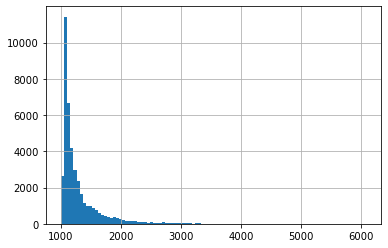

In [43]:
df["rev_fresh"].hist(bins=100)

Похоже на [логнормальное распределение](http://sixsigmaonline.ru/baza-znanij/22-1-0-229#_22).

In [44]:
df["rev_fresh"].describe()

count    41885.000000
mean      1303.027862
std        363.238775
min       1013.000000
25%       1092.000000
50%       1166.000000
75%       1350.000000
max       6072.000000
Name: rev_fresh, dtype: float64

Львиная доля отзывов оставлена около трех лет назад, но есть и сосвем старые отзывы. Посмотрим, повлияет ли эта информация на точность прогнозов.

<AxesSubplot:>

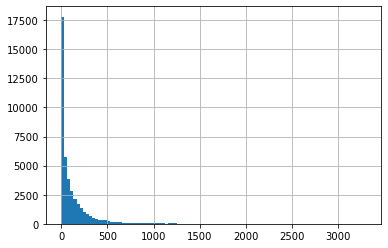

In [45]:
# Посмотрим теперь на распределение нового признака date_delta:

df["date_delta"].hist(bins=100)

Здесь мы скорее всего имеем дело с [экспоненциальным распределением](http://sixsigmaonline.ru/baza-znanij/22-1-0-229#_16), которое моделирует время между двумя последовательными появлениями одного и того же события.

In [46]:
df.head(3)

,city,c_style,ranking,p_range,n_reviews,sample,rating,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN,rev_single,date_1,date_2,date_delta,rev_fresh
0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,0,0.0,0,0,0,1,0,NaT,NaT,NaN,NaN
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,0,0.0,0,0,0,0,0,2017-12-05,2017-10-29,37.0,1096.0
2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,0,0.0,0,0,0,0,0,2017-12-28,2017-12-06,22.0,1073.0


In [47]:
df.isna().sum()

city                   0
c_style            11590
ranking                0
p_range            17361
n_reviews              0
sample                 0
rating                 0
n_reviews_isNAN        0
c_style_isNAN          0
p_range_isNAN          0
reviews_isNAN          0
rev_single             0
date_1              8115
date_2              8115
date_delta          8115
rev_fresh           8115
dtype: int64

In [48]:
# Избавимся от колонок date_1 и date_2, они нам больше не понадобятся:
df.drop(["date_1", "date_2"], 1, inplace=True)

In [49]:
df.isna().sum()

city                   0
c_style            11590
ranking                0
p_range            17361
n_reviews              0
sample                 0
rating                 0
n_reviews_isNAN        0
c_style_isNAN          0
p_range_isNAN          0
reviews_isNAN          0
rev_single             0
date_delta          8115
rev_fresh           8115
dtype: int64

Заполним 8115 пропусков в признаках *date_delta* и *rev_fresh*:

In [50]:
df["date_delta"].fillna(method="bfill", inplace=True)
df["rev_fresh"].fillna(method="bfill", inplace=True)

**Итог: Из признака *reviews* мы сконструировали новых признака:**
1. reviews_isNAN - информация о пропусках
2. rev_single - один отзыв или больше
3. date_delta - кол-во дней между последними отзывами
4. rev_fresh - кол-во дней с последнего отзыва

### p_range: Цены в ресторане в 3 категориях

Теперь разберемся с *p_range*. Этот признак описывает порядок цен в каждом ресторане. Приведем его значения к числовым.

In [51]:
def p_range(row):
    if type(row.p_range) == float:
        return row.p_range
    elif row.p_range == "$":
        return 1
    elif row.p_range == "$$ - $$$":
        return 2
    return 3
    return row.p_range

In [52]:
df["p_range"] = df.apply(p_range, axis=1)

In [53]:
df.sample(5)

,city,c_style,ranking,p_range,n_reviews,sample,rating,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN,rev_single,date_delta,rev_fresh
30754,Paris,NaN,6583.0,NaN,18.0,1,4.0,0,1,1,0,0,333.0,1201.0
27514,Brussels,"['Belgian', 'Fast Food', 'European']",188.0,1.0,366.0,1,4.0,0,0,0,0,0,0.0,1111.0
30508,Rome,"['Italian', 'Seafood', 'Mediterranean']",2591.0,2.0,155.0,1,4.5,0,0,0,0,0,1.0,1966.0
12561,London,['European'],11959.0,NaN,7.0,1,4.5,0,0,1,0,0,357.0,2288.0
26902,Rome,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",3549.0,2.0,115.0,1,4.0,0,0,0,0,0,104.0,1177.0


In [54]:
df.p_range.value_counts(dropna=False)

2.0    23041
NaN    17361
1.0     7816
3.0     1782
Name: p_range, dtype: int64

<AxesSubplot:>

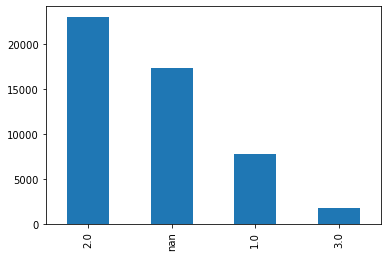

In [55]:
df.p_range.value_counts(dropna=False).plot(kind="bar")

Чаще всего встречается значение 2: средний уровень цен. Также наблюдаем большое кол-во пропусков в признаке - 15650. С пропусками в этом признаками разберемся чуть позже.

**Итог: Ординальный признак *p_range* получил числовые значения. Создан новый признак:**
1. p_range_isNAN - информация о пропусках

### c_style: Кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане

Теперь разберемся с признаком *c_style* (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане).

Сам по себе он мало полезен для нашей модели, но из него мы можем сконструировать новые признаки:
1. *n_style* - количество кухонь, предлагаемых в ресторане
2. *top_cuis* - кол-во кухонь из топ пять самых **популярных** кухонь, предлагаемых в ресторане.
3. *unique_cuis* - кол-во кухонь из 20 самых **редких** кухонь, предлагаемых в ресторане.
* Кроме того, на основе признака *c_style* мы можем создать **фиктивные переменные**.

In [56]:
# Переведем str в list

df["c_style"] = df.c_style.apply(lambda x: x.split(",") if type(x) == str else x)

In [57]:
# Уберем лишнее

for lst in df["c_style"]:
    if type(lst) == list:
        for i in range(len(lst)):
            lst[i] = lst[i].replace("[", "").strip()
            lst[i] = lst[i].replace("'", "").strip()
            lst[i] = lst[i].replace("]", "").strip()
            
print(df["c_style"][4])

['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']


In [58]:
# Заполним пропуски в c_style популярной кухней European

df["c_style"] = df.c_style.apply(lambda x: ["European"] if type(x) == float else x)

In [59]:
# Создадим признак n_style - кол-во кухонь, предлагаемых в ресторане

df["n_style"] = df.c_style.apply(lambda x: len(x) if type(x) == list else x)

<AxesSubplot:>

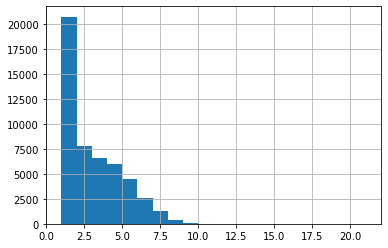

In [60]:
# Посмотрим на распределение нового признака

df.n_style.hist(bins=20)

Добавим аннонсированный ранее признак *top_cuis*, содержащий кол-во кухонь из топ пять самых популярных кухонь, предлагаемых в ресторане:

In [61]:
# Создадим лист, содержащий кухни из каждого наблюдения датасета

cuis = []

for lst in df.c_style:
    if type(lst) == list:
        for el in lst:
            cuis.append(el)
            
            
# Отберем топ пять самых часто встречающихся кухонь и поместим их в множество

top_cuis = set(pd.Series(cuis).value_counts().head().index.to_list())
print(top_cuis)

{'Mediterranean', 'Vegan Options', 'European', 'Vegetarian Friendly', 'Italian'}


In [62]:
# Поместим все кухни в лист, пригодится

cuis_lst = sorted(list(set(pd.Series(cuis).value_counts().index.to_list())))

In [63]:
# Превратим списки из c_style в множества

df["c_style"] = df.c_style.apply(lambda x: set(x) if type(x) != float else x)

In [64]:
# Создадим признак top_cuis, являющийся длиной пересечения множества из c_style и множества top_cuis

df["top_cuis"] = df.c_style.apply(lambda x: len(x.intersection(top_cuis)) if type(x) != float else x)

Теперь сконструируем признак *unique_cuis*, содержащий информацию о количестве редких кухонь, предлагаемых в ресторане.

In [65]:
# Сначала отберем 20 самых редких кухонь и поместим их в множество

unique_cuis = set(pd.Series(cuis).value_counts(ascending=False).tail(20).index.to_list())
print(unique_cuis)

{'Xinjiang', 'Yunnan', 'New Zealand', 'Azerbaijani', 'Fujian', 'Minority Chinese', 'Polynesian', 'Caucasian', 'Welsh', 'Central Asian', 'Romanian', 'Native American', 'Canadian', 'Salvadoran', 'Albanian', 'Ecuadorean', 'Latvian', 'Chilean', 'Uzbek', 'Burmese'}


In [66]:
# Создадим признак unique_cuis, являющийся длиной пересечения множества из c_style и множества unique_cuis

df["unique_cuis"] = df.c_style.apply(lambda x: len(x.intersection(unique_cuis)) if type(x) != float else x)

In [67]:
df["unique_cuis"].value_counts()

0    49891
1      106
2        2
3        1
Name: unique_cuis, dtype: int64

Как видим, редкие кухни встречаются довольно редко. Позже проверим, влияет ли новый признак на нашу целевую переменную.

Наконец, создадим фиктивные переменные (dummy variables) по принципу **One-hot-encoding**. Для этого воспользуемся [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) из библиотеки **sklearn**.

In [68]:
mlb = MultiLabelBinarizer()

In [69]:
df_columns_for_mlb = df.drop("c_style", 1).columns.to_list()

In [70]:
cuisines = mlb.fit_transform(df.pop('c_style'))

In [71]:
cuisines

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
df = pd.concat([df, pd.DataFrame(cuisines)], 1)

In [73]:
df.columns = df_columns_for_mlb + list(mlb.classes_)

In [74]:
df.head()

,city,ranking,p_range,n_reviews,sample,rating,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,Paris,12963.0,2.0,4.0,0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Helsinki,106.0,2.0,97.0,0,0.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,Edinburgh,810.0,2.0,28.0,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,London,1669.0,3.0,202.0,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Bratislava,37.0,3.0,162.0,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Итог: Пропуски в *c_style* заменены популярной кухней European; Из признака *c_style* было создано несколько новых переменных:
1. *c_style_isNAN* - информация о пропусках
2. *n_style* - количество кухонь, предлагаемых в ресторане
3. *top_cuis* - кол-во кухонь из топ пять самых **популярных** кухонь, предлагаемых в ресторане.
4. *unique_cuis* - кол-во кухонь из 20 самых **редких** кухонь, предлагаемых в ресторане.
5. Фиктивные dummy-переменные.

## city: город, в котором находится ресторан

In [75]:
print(f"В признаке 'city' {df.city.isna().sum()} пропущенных значений")
print(f"Признак 'city' принимает {df.city.nunique()} уникальных значений")

В признаке 'city' 0 пропущенных значений
Признак 'city' принимает 31 уникальных значений


Посмотрим, рестораны каких городов представлены в датасете чаще всего:

<AxesSubplot:>

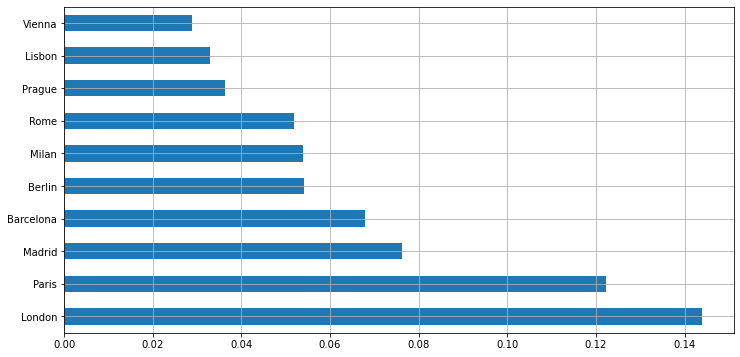

In [76]:
plt.rcParams['figure.figsize'] = (12,6)
df["city"].value_counts(normalize=True).head(10).plot(kind="barh", grid=True)

По количеству ресторанов лидируют столицы Великобритании, Франции и Испании.

Из признака *city* сконструируем несколько новых переменных.

Начнем с того, что закодируем этот признак с помощью [**CountEncoder**](https://contrib.scikit-learn.org/category_encoders/count.html) (заменяет значение переменной числом повторений этого значения в столбце). *Позже добавим также **dummy-переменные** для этого признака.*

In [77]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(df["city"])
df = df.join(count_encoded.add_suffix("_count"))

In [78]:
cities_lst = sorted(df.city.unique().tolist())

Воспользуемся [внешними источниками](https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits) и добавим информацию кол-ве жителей в каждом городе (в тыс человек):

In [79]:
cities_pop = {'Amsterdam': 821, 'Athens': 664, 'Barcelona': 1620,'Berlin': 3769,'Bratislava': 424,
              'Brussels': 174,'Budapest': 1752,'Copenhagen': 602,'Dublin': 1388,'Edinburgh': 482,
              'Geneva': 500,'Hamburg': 1841,'Helsinki': 632,'Krakow': 775,'Lisbon': 505,'Ljubljana': 280,
              'London': 8962,'Luxembourg': 614,'Lyon': 513,'Madrid': 3348,'Milan': 1404,'Munich': 1484,'Oporto': 214,
              'Oslo':681,'Paris': 2140,'Prague': 1324,'Rome': 2856,'Stockholm': 974,'Vienna': 1911,'Warsaw': 1793,'Zurich': 403}

In [80]:
df["cities_pop"] = df['city'].map(lambda x: cities_pop.get(x,x))

Добавим список, содержащий информацию о странах:

In [81]:
countries = {'London': 'UK', 
             'Paris': 'France', 
             'Madrid': 'Spain', 
             'Barcelona': 'Spain', 
             'Berlin': 'Germany', 
             'Milan': 'Italy', 
             'Rome': 'Italy', 
             'Prague': 'Czech Rep', 
             'Lisbon': 'Portugal', 
             'Vienna': 'Austria', 
             'Amsterdam': 'Netherlands', 
             'Brussels': 'Belgium', 
             'Hamburg': 'Germany', 
             'Munich': 'Germany', 
             'Lyon': 'France', 
             'Stockholm': 'Sweden', 
             'Budapest': 'Romania', 
             'Warsaw': 'Poland', 
             'Dublin': 'Ireland', 
             'Copenhagen': 'Denmark', 
             'Athens': 'Greece', 
             'Edinburgh': 'Scotland', 
             'Zurich': 'Switzerland', 
             'Oporto': 'Portugal', 
             'Geneva': 'Switzerland', 
             'Krakow': 'Poland', 
             'Oslo': 'Norway', 
             'Helsinki': 'Finland', 
             'Bratislava': 'Slovakia', 
             'Luxembourg': 'GD of Luxembourg', 
             'Ljubljana': 'Slovenia'}

In [82]:
countries_lst = sorted(list(countries.values()))

In [83]:
df["country"] = df['city'].map(lambda x: countries.get(x,x))

Также закодируем признак *country* через CountEncoder:

In [84]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(df["country"])
df = df.join(count_encoded.add_suffix("_count"))

Добавим признак с информацией о популярности страны для туризма. [Собрана информация](https://ec.europa.eu/eurostat/statistics-explained/index.php/Tourism_statistics) о кол-ве ночей в год, проведенных в стране нерезидентами (в млн)

In [85]:
# Nights spent in country by non residents (mln)

tourism_vol = {'Austria': 89.3, 'Belgium': 20.6, 'Czech Rep': 26.8, 'Denmark': 12.6, 'UK': 127, 'Finland': 6.8,
                'France': 140.7, 'GD of Luxembourg': 1.6, 'Germany': 87, 'Greece': 102.6, 'Netherlands': 47, 'Ireland': 16.8,
                'Italy': 216.5, 'Norway': 10.1, 'Poland': 17.7, 'Portugal': 49.9, 'Romania': 5.3, 'Scotland': 11.2,
                'Slovakia': 5.6, 'Slovenia': 11.2, 'Spain': 301, 'Sweden': 15.7, 'Switzerland': 26.7}

In [86]:
df["tourism"] = df['country'].map(lambda x: tourism_vol.get(x,x))

Наконец, добавим признак, хранящий информацию об уровне жизни в городе - [ВВП на душу населения для городов](https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita) (USD).

In [87]:
GDPperCapita = {'London': 58827, 
             'Paris': 61883, 
             'Madrid': 43074, 
             'Barcelona': 45752, 
             'Berlin': 37601, 
             'Milan': 51768, 
             'Rome': 41475, 
             'Prague': 48160, 
             'Lisbon': 34782, 
             'Vienna': 46787, 
             'Amsterdam': 60857, 
             'Brussels': 54634, 
             'Hamburg': 52947, 
             'Munich': 69844, 
             'Lyon': 46913, 
             'Stockholm': 61754, 
             'Budapest': 37399, 
             'Warsaw': 49722, 
             'Dublin': 59798, 
             'Copenhagen': 54197, 
             'Athens': 32167, 
             'Edinburgh': 44059, 
             'Zurich': 64302, 
             'Oporto': 24819, 
             'Geneva': 62115, 
             'Krakow': 29695, 
             'Oslo': 64673, 
             'Helsinki': 49760, 
             'Bratislava': 67841, 
             'Luxembourg': 88312, 
             'Ljubljana': 39763}

In [88]:
df["GDP"] = df['city'].map(lambda x: GDPperCapita.get(x,x))

In [89]:
# # GDP per capita PPP (USD) - для стран

# GDPperCapita = {'Austria': 56352, 'Belgium': 51708, 'Czech Rep': 40314, 'Denmark': 57184, 'UK': 46699, 'Finland': 48621,
#                 'France': 46184, 'GD of Luxembourg': 114482, 'Germany': 53815, 'Greece': 30315, 'Netherlands': 57141, 'Ireland': 86781,
#                 'Italy': 42413, 'Norway': 63633, 'Poland': 33086, 'Portugal': 34798, 'Romania': 29909, 'Scotland': 46699,
#                 'Slovakia': 32793, 'Slovenia': 38689, 'Spain': 40883, 'Sweden': 53205, 'Switzerland': 68628}

Руководствуясь житейской логикой (а иногда просто наугад), создадим из полученных выше признаков новые признаки!

In [90]:
# city_count взвешенный по населенности города
df["city_count_pop"] = df["city_count"] / df["cities_pop"]

In [91]:
# country_count взвешенный по объему туризма в стране
df["country_count_tourism"] = round(df["country_count"] / df["tourism"], 2)

# city_count взвешенный по объему туризма в стране
df["city_count_tourism"] = round(df["city_count"] / df["tourism"], 2)

In [92]:
# GDP взвешенный по city_count
df["GDP_city_count"] = round(df["GDP"] / df["city_count"], 2)

# GDP взвешенный по city_pop
df["GDP_city_pop"] = round(df["GDP"] / df["cities_pop"], 2)

# GDP взвешенный по tourism
df["GDP_tourism"] = round(df["GDP"] / df["tourism"], 2)

In [93]:
# # GDP взвешенный по уровню цен
# df["GDP_p_range"] = round(df["GDP"] / df["p_range"], 2)

# Добавим после, когда устраним пропуски в p_range

In [94]:
# Кол-во отзывов / население
df["n_rev_pop"] = df["n_reviews"] / df["cities_pop"]

# Кол-во отзывов / объем туризма
df["n_rev_tourism"] = df["n_reviews"] / df["tourism"]

In [95]:
# Средняя цена в городе
price_in_city_dict = df.groupby('city')['p_range'].mean().to_dict()
df['city_p_range'] = df['city'].map(price_in_city_dict)

In [96]:
# Среднее количество отзывов в городе
n_rev_in_city_dict = df.groupby('city')['n_reviews'].mean().to_dict()
df['city_n_rev'] = df['city'].map(n_rev_in_city_dict)

In [97]:
# Среднее кол-во кухонь, предлагаемых в городе
cuis_in_city_dict = df.groupby('city')['n_style'].mean().to_dict()
df['city_n_style'] = df['city'].map(cuis_in_city_dict)

In [98]:
# Максимальное количество отзывов в городе
max_n_rev_in_city_dict = df.groupby('city')['n_reviews'].max().to_dict()
df['city_n_rev_max'] = df['city'].map(max_n_rev_in_city_dict)

Для *country* и *city* добавим фиктивные переменные:

In [99]:
df = pd.get_dummies(df, columns=["city", "country"], dummy_na=True)

In [100]:
df.shape

(50000, 213)

**Итог: Из категориальной (номинальной) переменной *city* были сконструированы следующие признаки:**
1. *city_count* - кол-во повторений каждого значения признака city
2. *cities_pop* - размер населения города в тыс. жителей
3. *country* - страна, в которой находится ресторан
4. *country_count* - кол-во повторений каждого значения признака country
5. *tourism* - признак, сообщающий информацию об объеме туризма в стране ресторана (млн ночей в год, проведенных в стране нерезидентами)
6. *GDP* - информация об уровне жизни в городе: ВВП на душу населения города ($)

7. *city_count_pop* - city_count взвешенный по населенности города
8. *country_count_tourism* - country_count взвешенный по объему туризма в стране
9. *city_count_tourism* - city_count взвешенный по объему туризма в стране
10. *GDP_city_count* - GDP взвешенный по city_count
11. *GDP_city_pop* - GDP взвешенный по city_pop
12. *GDP_tourism* - GDP взвешенный по tourism
13. *GDP_p_range* - GDP взвешенный по уровню цен (добавлю ниже, устранив пропуски)
14. *n_rev_pop* - кол-во отзывов для ресторана к населению города
15. *n_rev_tourism* - кол-во отзывов для ресторана к объему туризма в стране
16. *city_p_range* - средняя цена в городе
17. *city_n_rev* - среднее количество отзывов в городе
18. *city_n_style* - среднее кол-во кухонь, предлагаемых в городе
19. *city_n_rev_max* - максимальное количество отзывов в городе
20. *dummy для city*
21. *dummy для country*

### ranking: место, которое занимает ресторан среди всех ресторанов своего города

*ranking* - важный признак, один из немногих, оказывающих непосредственное влияние на цел. переменную.

In [101]:
df_train.loc[:, ["Ranking", "Rating"]].corr()

,Ranking,Rating
Ranking,1.000000,-0.368371
Rating,-0.368371,1.000000


Прежде чем мы начнем работу с ним, избавимся от пропусков в признаке *p_range*. Для этого воспользуемся пакетом [IterativeImputer](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) из **sklearn**, который моделирует каждый признак с пропущенными значениями как функцию других признаков, используя ее для заполнения пропусков. В качестве алгоритма используем **Decision Tree Regressor**.

In [102]:
df.p_range.isna().sum()

17361

In [103]:
imp = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=10, verbose=0, random_state=4)

# В обучении алгоритма не участвует целевая переменная, чтобы избежать data leakage:
df_imp = pd.DataFrame(imp.fit_transform(df.drop("rating", 1)))

df_imp.columns = df.drop("rating", 1).columns.to_list()

df = pd.concat([df.loc[:, "rating"], df_imp], 1)

In [104]:
df.p_range.value_counts(dropna=False)

2.0    33428
1.0    13933
3.0     2639
Name: p_range, dtype: int64

Посмотрим, как алгоритм распределил значения среди более чем 15 тысяч пропусков

In [105]:
df[df.p_range_isNAN == 1].p_range.value_counts(normalize=True)

2.0    0.598295
1.0    0.352341
3.0    0.049364
Name: p_range, dtype: float64

Чуть менее 60 процентов пришлось на среднюю ценовую категорию, около одной трети - на категорию ниже среднего. 6 процентов пропусков были заполнены значением, обозначающим категорию цен выше среднего.

In [106]:
df.city_count

0        6108.0
1         475.0
2         745.0
3        7193.0
4         380.0
          ...  
49995    2694.0
49996    6108.0
49997    1033.0
49998     925.0
49999    2694.0
Name: city_count, Length: 50000, dtype: float64

Переменная *ranking* описывает место, которое занимает данный ресторан **среди всех ресторанов своего города**. Предлагаю создать пременную *ranking_pure* = *rnaking* / *city_count*, которая будет хранить информацию о качестве ресторана, очищенную от влияния размера города. Напомню, что переменная *city_count* содержит числа повторений того или иного города в датасете. Взаимосвязь между *ranking* и *city_count* хорошо видна из корреляционной матрицы ниже (коэф. корр. Пирсона = 0,70):

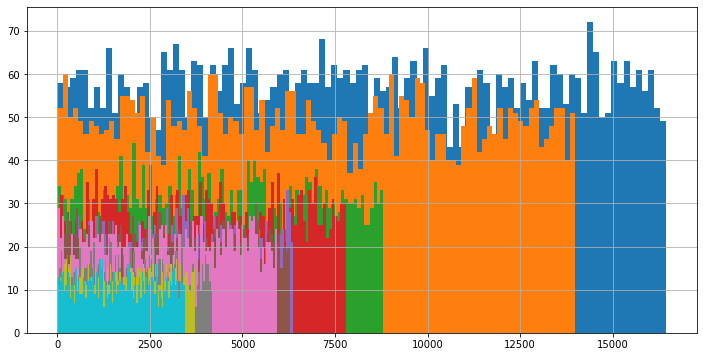

In [107]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [108]:
# Здесь создам список с названиями признаков, которые не хочу видеть в корр. матрице

countries_lst = list(set(countries_lst))
cities_lst = list(set(cities_lst))

prefix_city = "city_"
prefix_country = "country_"

cities_lst_drop = [prefix_city + x for x in cities_lst]
countries_lst_drop = [prefix_country + x for x in countries_lst]

columns_to_drop = list(set(cuis_lst + cities_lst_drop + countries_lst_drop))

In [109]:
corr_matrix = df[df["sample"] == 1].drop(columns_to_drop, 1).drop(["sample", "city_nan", "country_nan"], 1).corr()
display(corr_matrix)

,rating,ranking,p_range,n_reviews,n_reviews_isNAN,c_style_isNAN,p_range_isNAN,reviews_isNAN,rev_single,date_delta,...,city_count_tourism,GDP_city_count,GDP_city_pop,GDP_tourism,n_rev_pop,n_rev_tourism,city_p_range,city_n_rev,city_n_style,city_n_rev_max
rating,1.000000,-0.368371,-0.024487,0.026938,0.008386,-0.038263,-0.064567,-0.024727,0.008562,-0.067439,...,0.003188,0.016010,-0.005729,-0.002662,0.023874,0.028828,-0.076125,0.050662,0.081707,-0.019094
ranking,-0.368371,1.000000,-0.056427,-0.222030,0.094078,0.147995,0.233043,0.106386,0.085453,0.084179,...,0.036733,-0.416794,-0.341766,-0.201388,-0.206234,-0.143447,0.069413,0.102007,-0.074345,0.554007
p_range,-0.024487,-0.056427,1.000000,0.160052,-0.034805,-0.079124,-0.103880,-0.028298,-0.072403,-0.026027,...,0.000319,0.039006,0.039318,0.025019,0.098634,0.077116,0.162551,-0.042940,-0.045581,0.020271
n_reviews,0.026938,-0.222030,0.160052,1.000000,-0.105541,-0.201260,-0.266721,-0.163576,-0.128925,-0.116331,...,-0.007033,-0.048185,-0.037855,-0.022092,0.600298,0.439691,-0.083284,0.175619,0.097100,0.101716
n_reviews_isNAN,0.008386,0.094078,-0.034805,-0.105541,1.000000,0.186118,0.266923,0.329887,0.211646,-0.055110,...,0.017979,0.015745,0.003761,0.010512,-0.073222,-0.046467,-0.007370,-0.052629,-0.010608,-0.038578
c_style_isNAN,-0.038263,0.147995,-0.079124,-0.201260,0.186118,1.000000,0.753881,0.272140,0.189826,0.048546,...,-0.046449,0.007114,0.009457,-0.010398,-0.138327,-0.090943,0.039404,-0.113051,-0.123611,-0.099099
p_range_isNAN,-0.064567,0.233043,-0.103880,-0.266721,0.266923,0.753881,1.000000,0.414213,0.244130,0.084441,...,-0.034951,0.006124,0.000677,-0.006045,-0.185150,-0.121014,0.032095,-0.120937,-0.128899,-0.100110
reviews_isNAN,-0.024727,0.106386,-0.028298,-0.163576,0.329887,0.272140,0.414213,1.000000,-0.157525,0.009844,...,-0.164263,-0.061161,-0.023850,-0.059611,-0.115118,-0.076597,0.003382,-0.020009,-0.204416,-0.072669
rev_single,0.008562,0.085453,-0.072403,-0.128925,0.211646,0.189826,0.244130,-0.157525,1.000000,-0.206354,...,-0.031622,0.005123,0.006287,-0.001620,-0.091017,-0.060900,0.021106,-0.045651,-0.076646,-0.057164
date_delta,-0.067439,0.084179,-0.026027,-0.116331,-0.055110,0.048546,0.084441,0.009844,-0.206354,1.000000,...,-0.037727,0.003421,0.005600,-0.003328,-0.081542,-0.064447,0.028900,-0.036954,-0.077705,-0.039235


<AxesSubplot:>

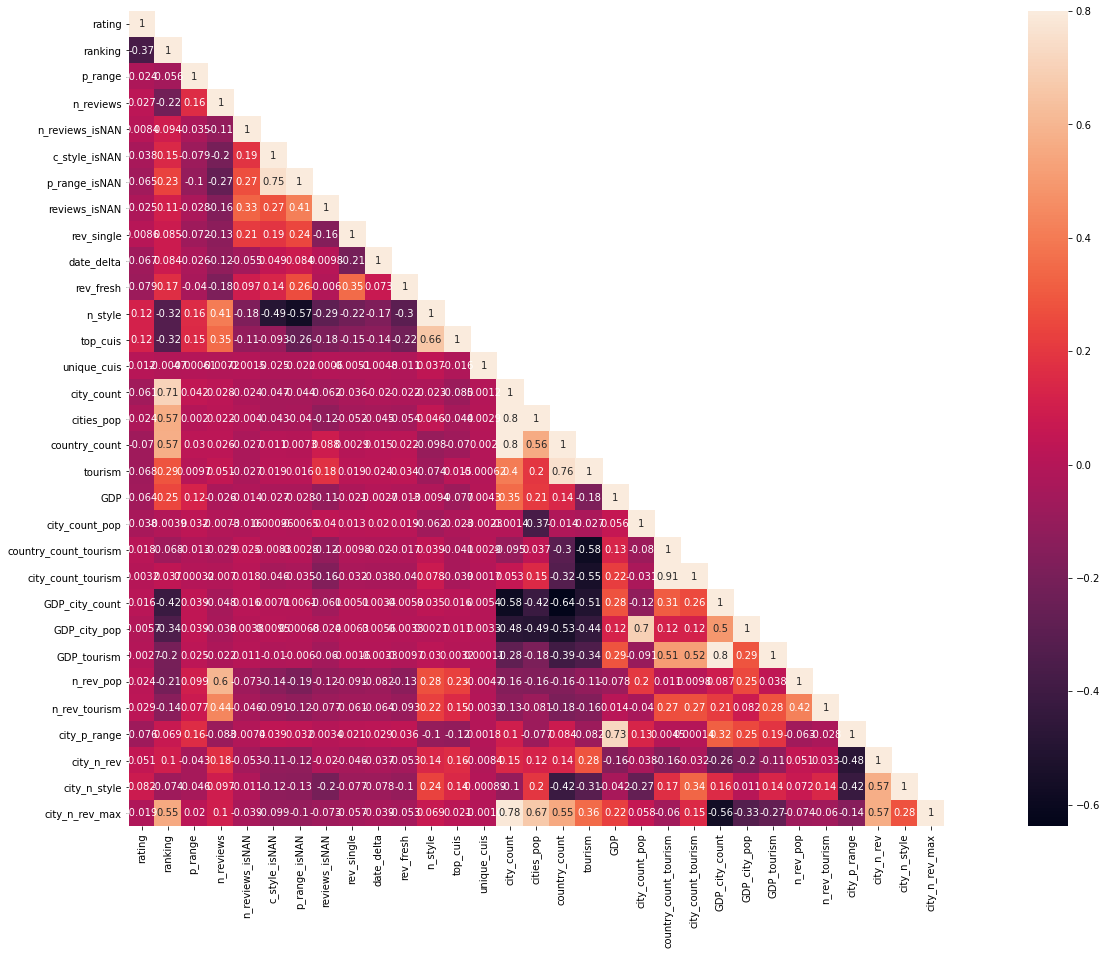

In [110]:
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,15)
sns.heatmap(corr_matrix, mask=mask, vmax=.8, square=True, annot=True)

In [111]:
# создаем переменную ranking_pure
df["ranking_pure"] = df.ranking / df.city_count

In [112]:
corr_matrix_new = df[df["sample"] == 1].drop(columns_to_drop, 1).drop(["sample", 
                                                                       "city_nan", "country_nan"], 1).corr()

In [113]:
corr_matrix_new[abs(corr_matrix_new.ranking_pure) > 0.3].ranking_pure

rating          -0.543724
ranking          0.557146
n_reviews       -0.406382
c_style_isNAN    0.323033
p_range_isNAN    0.463439
rev_fresh        0.320608
n_style         -0.540847
top_cuis        -0.450628
ranking_pure     1.000000
Name: ranking_pure, dtype: float64

Новая переменная хорошо скоррелированна с многими признаками:
* Чем ниже ранг (лучше ресторан), тем выше его рейтинг
* Чем больше отзывов, тем лучше ресторан
* Больше представлено кухонь - лучше ресторан
* Рестораны со свежеми отзывами как правило выше оценены

In [114]:
# Добавим также эту переменную с возведенными в квадрат значениями
df["ranking_pure_2"] = df.ranking_pure ** 2

**Далее на основе признака *ranking* / *ranking_pure* сконструируем новые переменные:**

In [115]:
# # Чистый ранг к населению
# df['ranking_pure_pop'] = df.ranking_pure / df.cities_pop

# # Кол-во отзывов деленное на чистый ранг
# df["ranking_pure_n_reviews"] = df["n_reviews"] / df["ranking_pure"] # чемы выше, тем выше target 

# # Кол-во кухонь деленное на чистый ранг
# df["ranking_pure_n_style"] = df["n_style"] / df["ranking_pure"] # чемы выше, тем выше target

# Ранг ресторана с учетом частоты отзывов в городе
df['rank_pure_rev_pop'] =  df['ranking_pure']  *  df['n_rev_pop']

# Средняя цена в городе к чистому рангу
df["city_p_range_ranking_pure"] = df['city_p_range'] / df['ranking_pure']

# Среднее кол-во отзывов в городе к чистому рангу
df["city_n_rev_ranking_pure"] = df['city_n_rev'] / df['ranking_pure']

# Среднее кол-во кухонь в городе к чистому рангу
df["city_n_style_ranking_pure"] = df['city_n_style'] / df['ranking_pure']

# Максимальное кол-во кухонь в городе к чистому рангу
df["city_n_rev_max_ranking_pure"] = df['city_n_rev_max'] / df['ranking_pure']

In [116]:
# GDP взвешенный по уровню цен
df["GDP_p_range"] = round(df["GDP"] / df["p_range"], 4)

In [117]:
df.iloc[:, -13:].head().T

,0,1,2,3,4
country_Spain,0.000000,0.000000,0.000000,0.000000,0.000000
country_Sweden,0.000000,0.000000,0.000000,0.000000,0.000000
country_Switzerland,0.000000,0.000000,0.000000,0.000000,0.000000
country_UK,0.000000,0.000000,0.000000,1.000000,0.000000
country_nan,0.000000,0.000000,0.000000,0.000000,0.000000
ranking_pure,2.122299,0.223158,1.087248,0.232031,0.097368
ranking_pure_2,4.504151,0.049799,1.182109,0.053838,0.009481
rank_pure_rev_pop,0.003967,0.034250,0.063160,0.005230,0.037202
city_p_range_ranking_pure,0.891380,8.368549,1.572778,7.795899,19.140049
city_n_rev_ranking_pure,52.526036,278.613208,212.495062,559.702816,451.378378


**Итог: Из числовой переменной *ranking* были сконструированы следующие признаки:**
1. *ranking_pure* - нормализованный ранг
1. *ranking_pure_2* - нормализованный ранг в квадрате
1. *ranking_pure_pop* - чистый ранг к населению
1. *ranking_pure_n_reviews* - кол-во отзывов деленное на чистый ранг
1. *ranking_pure_n_style* - кол-во кухонь деленное на чистый ранг
1. *rank_pure_rev_pop* - ранг ресторана с учетом частоты отзывов в городе
1. *city_p_range_ranking_pure* - средняя цена в городе к чистому рангу
1. *city_n_rev_ranking_pure* - среднее кол-во отзывов в городе к чистому рангу
1. *city_n_style_ranking_pure* - среднее кол-во кухонь в городе к чистому рангу
1. *city_n_rev_max_ranking_pure* - максимальное кол-во кухонь в городе к чистому рангу

*Примечание: После исключения признаков 3, 4 и 5 точность модели повысилась.*

## Модель

In [118]:
# Теперь выделим тестовую часть
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_test = df.query('sample == 0').drop(['sample'], axis=1)

y = df_train.rating.values # наш таргет
X = df_train.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [119]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [120]:
# проверяем
df_test.shape, df_train.shape, X.shape, X_train.shape, X_test.shape

((10000, 220), (40000, 220), (40000, 219), (32000, 219), (8000, 219))

In [121]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [122]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [123]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s


Wall time: 41.6 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [124]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19873312499999998


<AxesSubplot:>

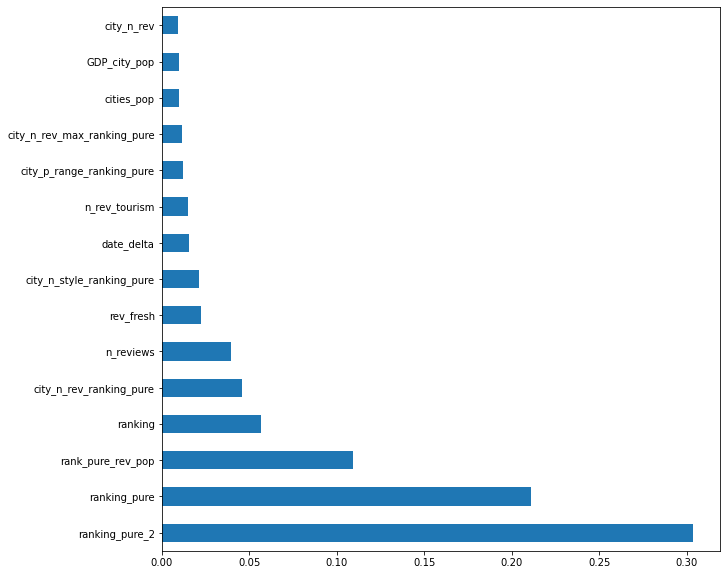

In [125]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [126]:
feat_importances.sort_values().tail(30)

city_Madrid                    0.001610
GDP                            0.001650
n_reviews_isNAN                0.001732
p_range_isNAN                  0.001794
GDP_tourism                    0.002548
top_cuis                       0.002784
city_count_tourism             0.002835
country_count                  0.003501
tourism                        0.003612
n_style                        0.005062
GDP_p_range                    0.005179
city_Rome                      0.006207
city_n_style                   0.006564
city_count_pop                 0.007572
n_rev_pop                      0.008655
city_n_rev                     0.008984
GDP_city_pop                   0.009635
cities_pop                     0.010008
city_n_rev_max_ranking_pure    0.011696
city_p_range_ranking_pure      0.012105
n_rev_tourism                  0.015019
date_delta                     0.015565
city_n_style_ranking_pure      0.021350
rev_fresh                      0.022263
n_reviews                      0.039404


Оставим признаки с важностью более 0.005 и проверим, как поведет себя модель.

In [127]:
feat_importances_top = feat_importances[feat_importances > 0.005]

In [128]:
feat_importances[feat_importances > 0.005].count()

21

<AxesSubplot:>

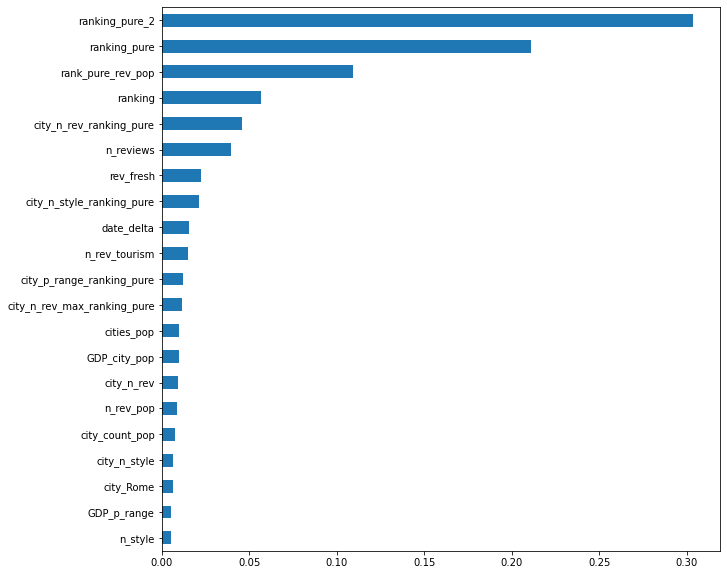

In [129]:
feat_importances_top.sort_values().plot(kind="barh")

In [130]:
to_keep = feat_importances_top.index.to_list() + ["sample", "rating"]

In [131]:
df_keep = df.loc[:, to_keep]

In [132]:
df_train = df_keep.query('sample == 1').drop(['sample'], axis=1)
df_test = df_keep.query('sample == 0').drop(['sample'], axis=1)

y = df_train.rating.values # наш таргет
X = df_train.drop(['rating'], axis=1)

In [133]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_top30 = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s


Wall time: 13.2 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [134]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_top30))

MAE: 0.20050437499999998


Модель, обученная на 21 самых важных признаках оказалась чуть менее точной. 

<AxesSubplot:>

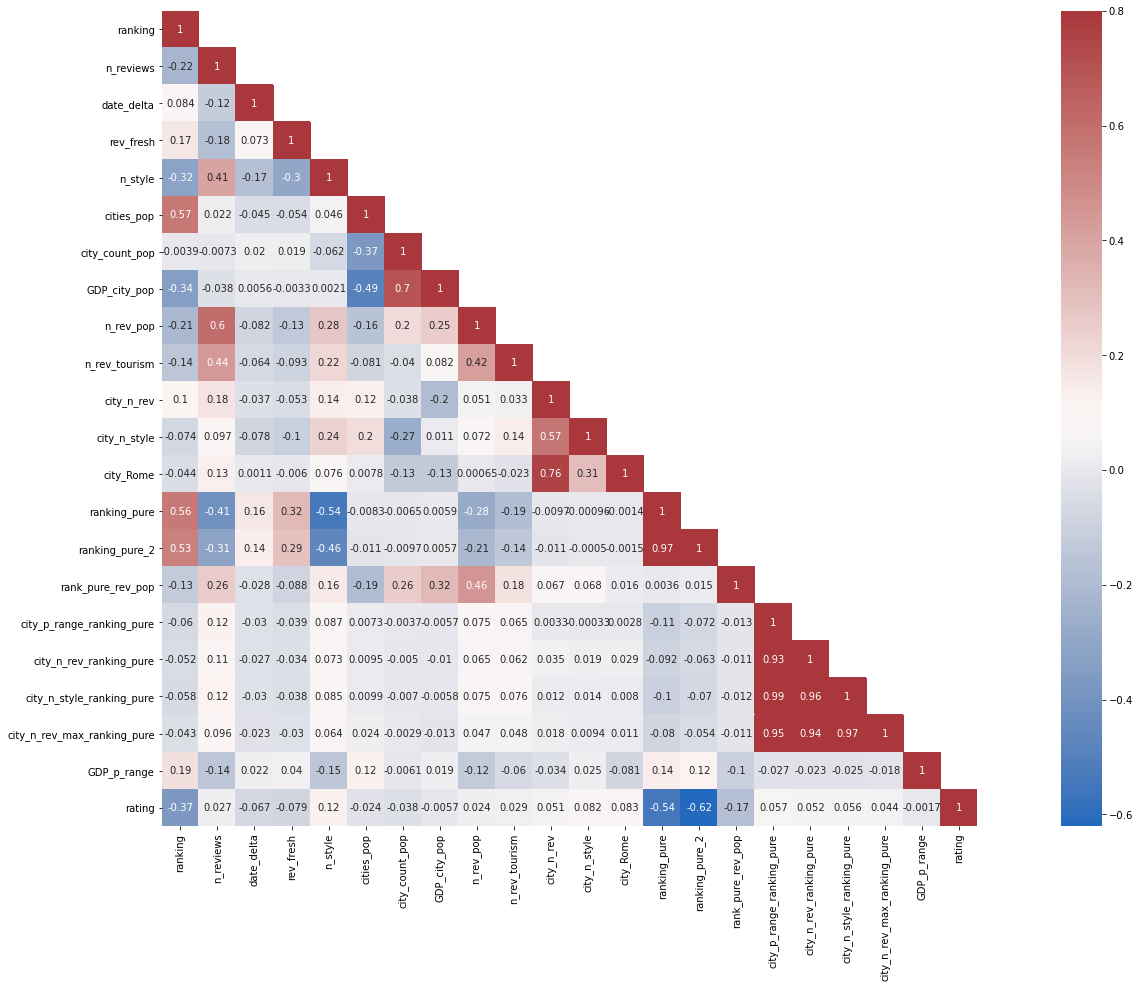

In [135]:
mask = np.array(df_keep[df_keep["sample"] == 1].drop("sample", 1).corr())
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,15)
sns.heatmap(df_keep[df_keep["sample"] == 1].drop("sample", 1).corr(), mask=mask, vmax=.8, square=True, annot=True, cmap='vlag')

# Submission

In [136]:
df_test.sample(10)

,ranking,n_reviews,date_delta,rev_fresh,n_style,cities_pop,city_count_pop,GDP_city_pop,n_rev_pop,n_rev_tourism,...,city_Rome,ranking_pure,ranking_pure_2,rank_pure_rev_pop,city_p_range_ranking_pure,city_n_rev_ranking_pure,city_n_style_ranking_pure,city_n_rev_max_ranking_pure,GDP_p_range,rating
6221,980.0,42.0,24.0,1067.0,6.0,505.0,3.261386,68.88,0.083168,0.841683,...,0.0,0.595021,0.354050,0.049487,2.907382,200.392857,4.464286,5720.804082,17391.0000,0.0
2731,2790.0,15.0,0.0,1655.0,1.0,3348.0,1.138889,12.87,0.004480,0.049834,...,0.0,0.731707,0.535396,0.003278,2.527238,128.029391,2.879211,8217.766667,21537.0000,0.0
572,5088.0,0.0,577.0,1384.0,1.0,3769.0,0.717697,9.98,0.000000,0.000000,...,0.0,1.880961,3.538015,0.000000,0.926704,30.660574,1.210299,1367.386006,18800.5000,0.0
6055,1779.0,12.0,0.0,4235.0,2.0,974.0,1.060575,63.40,0.012320,0.764331,...,0.0,1.722168,2.965864,0.021218,1.127786,40.261945,1.458123,848.349073,30877.0000,0.0
9565,325.0,7.0,40.0,2039.0,3.0,280.0,0.792857,142.01,0.025000,0.625000,...,0.0,1.463964,2.143190,0.036599,1.193223,56.249231,2.326154,1370.252308,19881.5000,0.0
6256,12920.0,27.0,411.0,1235.0,4.0,2140.0,2.854206,28.92,0.012617,0.191898,...,0.0,2.115259,4.474319,0.026688,0.894346,52.700851,1.012616,3603.341796,20627.6667,0.0
1019,5099.0,3.0,4.0,1558.0,1.0,1620.0,2.095679,28.24,0.001852,0.009967,...,0.0,1.501915,2.255747,0.002781,1.187673,84.230241,1.783879,3326.420867,45752.0000,0.0
8404,12148.0,19.0,17.0,1639.0,1.0,2140.0,2.854206,28.92,0.008879,0.135039,...,0.0,1.988867,3.955592,0.017658,0.951182,56.049967,1.076967,3832.332565,30941.5000,0.0
4226,3151.0,103.0,183.0,1146.0,2.0,3348.0,1.138889,12.87,0.030765,0.342193,...,0.0,0.826383,0.682910,0.025423,2.237701,113.361473,2.549349,7276.283402,21537.0000,0.0
7899,1002.0,25.0,12.0,1062.0,2.0,1752.0,0.582763,21.35,0.014269,4.716981,...,0.0,0.981391,0.963128,0.014004,1.750749,148.107784,3.340319,7718.637725,37399.0000,0.0


In [137]:
df_test = df_test.drop(['rating'], axis=1)

In [138]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [139]:
sample_submission.shape

(10000, 2)

In [140]:
df_test.shape

(10000, 21)

In [141]:
predict_submission = model.predict(df_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [142]:
predict_submission[:20]

array([2.97 , 4.29 , 4.415, 4.31 , 4.425, 4.46 , 2.26 , 2.98 , 4.045,
       4.61 , 4.04 , 3.82 , 3.99 , 4.005, 3.775, 3.02 , 3.65 , 4.125,
       2.705, 4.03 ])

In [143]:
len(predict_submission)

10000

In [144]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.970
1,id_1,4.290
2,id_2,4.415
3,id_3,4.310
4,id_4,4.425
5,id_5,4.460
6,id_6,2.260
7,id_7,2.980
8,id_8,4.045
9,id_9,4.610
